In [17]:
NUM_OF_AGENTS = 1000

# PLACES
PARK = 0
HOME = 1
GROCERY = 2
QC = 3 # Quarantine center

# INFECTION STATES
NOT_INFECTED = 0
INFECTED_A = 1
INFECTED_S = 2
CRITICAL = 3
CURED = 4
DECEASED = 5

# Capacity of quarantine center
QC_LIMIT = 100 # Capacity of quarantine center

In [18]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

class HumanAgent(Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.homeId = unique_id//4
        self.health = NOT_INFECTED

    def step(self):
        self.updateHealth()
        self.move()

    # Function for mobility pattern modeling
    
    def move(self):
        
        x, y = self.pos

        if x==QC:
            return
        
        if self.model.quarantine and self.model.QC_Occupancy < QC_LIMIT and self.health == CRITICAL:
            self.model.grid.move_agent(self, (QC,0))
            self.model.QC_Occupancy += 1
            return
        
        if self.model.quarantine and self.model.QC_Occupancy < QC_LIMIT and self.health == INFECTED_S and self.random.uniform(0, 1) <= 0.20:
            self.model.grid.move_agent(self, (QC,0))
            self.model.QC_Occupancy += 1
            return
        
        if x == HOME:
          
          p = self.random.uniform(0, 1)

          # Visit park with 10% probability
          if p <= 0.1:
            newX = PARK
            newY = self.random.choice((0,1)) # Visit one of the two parks
          # Visit grocery store with 20% probability
          elif p <= 0.3:
            newX = GROCERY
            newY = self.random.choice((0,1,2,3,4)) # Visit one of the five grocery stores
          else:
            newX = x
            newY = y

        if x == GROCERY or x == PARK: # If grocery or park, return home
          newX = HOME
          newY = self.homeId

        self.model.grid.move_agent(self, (newX,newY))

    # Function for modeling the spread of the virus

    def updateHealth(self):

        p = self.random.uniform(0, 1)
        
        if self.health == INFECTED_A and p > 0.75:
                self.health += 1
        elif self.health == INFECTED_S:
            if p > 0.75 and p <= 0.85:
                self.health += 1
            elif p > 0.85:
                self.health = CURED
                x,y = self.pos
                if x == QC:
                    self.model.QC_Occupancy -= 1                
        elif self.health == CRITICAL:
            if p > 0.75 and p <= 0.95:
                self.health += 1
                x,y = self.pos
                if x == QC:
                    self.model.QC_Occupancy -= 1
            elif p > 0.95:
                self.health = DECEASED
                self.model.deceasedCount += 1
                x,y = self.pos
                if x == QC:
                    self.model.QC_Occupancy -= 1
        return
    
    def infect(self):
        p = self.random.uniform(0, 1)
        if self.health == NOT_INFECTED and p > self.model.p0b:
                self.health += 1

def compute_infected(model):
    infectedAgents = [agent for agent in model.schedule.agents if agent.health in (INFECTED_A, INFECTED_S, CRITICAL) ]
    return len(infectedAgents)

class CovidModel(Model):

    """A model with some number of agents."""
    def __init__(self, N, startingState, quarantine = False, socialDistancing = False):

        self.num_agents = N
        # self.random.seed(42)
        self.QC_Occupancy = 0
        self.deceasedCount = 0
        self.quarantine = quarantine
        self.grid = MultiGrid(4 if quarantine else 3, 250, False)
        self.schedule = RandomActivation(self)
        self.running = True
        
        # With socialdistancing the probability of infection is 10% (p0b = 0.9) otherwise it is 50%
        self.p0b = 0.5
        
        # The next if block needs to be updated to correctly set infection probability when social distancing is TRUE
        #     quarantine center capacity needs to be changed too
        if socialDistancing:
            self.p0b = 0.9
        else:
            self.p0b = 0.5
        
        # creates agents
        for i in range(self.num_agents):
            a = HumanAgent(i, self)
            self.schedule.add(a)
            self.grid.place_agent(a, (HOME, a.homeId))

        for a in self.random.sample(self.schedule.agents,int(startingState*N)):
            a.health = INFECTED_A
        
        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_infected,
                             "QC_Occupancy": "QC_Occupancy"}
            )
        
    def step(self):

        self.datacollector.collect(self)
        '''Advance the model by one step.'''
        self.schedule.step()
        self.identifyAgentsAndUpdateSpread()

    def identifyAgentsAndUpdateSpread(self):

        # Park
        for y in range(2):
            agents = self.grid.get_cell_list_contents([(PARK,y)])
            self.updateSpread(agents)
        
        # Grocery
        for y in range(5):
            agents = self.grid.get_cell_list_contents([(GROCERY,y)])
            self.updateSpread(agents)
        
        # Home
        for y in range(250):
            agents = self.grid.get_cell_list_contents([(HOME,y)])
            self.updateSpread(agents)
    
    def updateSpread(self, agents):
        if any(a.health in (INFECTED_A, INFECTED_S, CRITICAL) for a in agents):
            [a.infect() for a in agents]

In [19]:

def runSimulation(startingState,quarantine=False,socialDistancing=False):
    
    modelInst = CovidModel(NUM_OF_AGENTS, startingState, quarantine, socialDistancing)
    i=0
    
    while any(a.health in (INFECTED_A, INFECTED_S, CRITICAL) for a in modelInst.schedule.agents):
        i += 1
        modelInst.step()
    
    modelDF = modelInst.datacollector.get_model_vars_dataframe()
    
    return i, modelInst.deceasedCount, modelDF.QC_Occupancy,modelDF.Infected

# Scenario 1a. No Quarantine Centers and No Social Distancing; 10% Infection at Start
StartingState = 10%

Quarantine=False

Social Distancing=False

Average number of days before stabilization: 44.6
Average of the Day with peak Infection (784.6): 5.1
Average Number of Casualties: 82.5


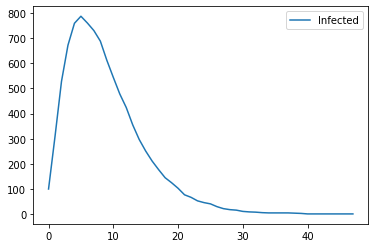

In [20]:
StartingState = 0.1
quarantine=False
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0

for i in range(10):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageCasualties += Casualties

    if i == 9:
        # QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))

# Scenario 1b. No Quarantine Centers and No Social Distancing; 25% Infection at Start
StartingState = 25%

Quarantine=False

Social Distancing=False

Average number of days before stabilization: 43.5
Average of the Day with peak Infection (796.0): 4.1
Average Number of Casualties: 82.7


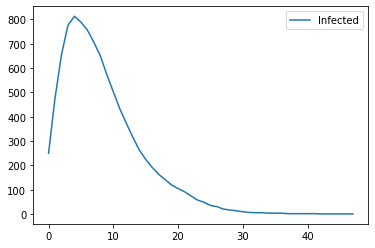

In [21]:
StartingState = 0.25
quarantine=False
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0

for i in range(10):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageCasualties += Casualties

    if i == 9:
        # QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))

# Scenario 1c. No Quarantine Centers and No Social Distancing; 50% Infection at Start
StartingState = 50%

Quarantine=False

Social Distancing=False

Average number of days before stabilization: 43.4
Average of the Day with peak Infection (846.5): 3.1
Average Number of Casualties: 85.1


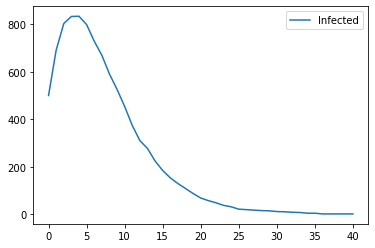

In [22]:
StartingState = 0.5
quarantine=False
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0

for i in range(10):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageCasualties += Casualties

    if i == 9:
        # QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))

# Adding Quarantine Centers
Enable quarantine centers for each baseline and see how the plots change
In the line plot, include a plot for capacity of qurantine center too

In [23]:
# Add code to generate plots with quarantine centers here

# Scenario 2a. Quarantine Centers; 10% Infection at start)
StartingState = 10%

Quarantine=True

Social Distancing=False

Average number of days before stabilization: 46.8
Average of the Day with peak Infection (760.6): 5.4
Average Number of Casualties: 77.2
Average of Max Quarantine centre capacity utilized: 100.0
Average of Max Quarantine centre capacity utilized at: 4.7


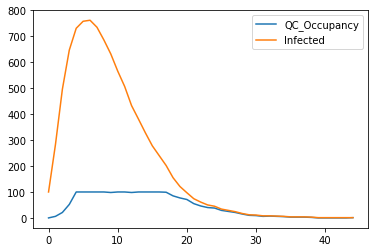

In [24]:
StartingState = 0.1
quarantine=True
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
averageMaxCapacityDay = 0
averageMaxCapacity = 0

for i in range(10):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties

    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))

# Scenario 2b. Quarantine Centers; 25% Infection at Start
StartingState = 25%

Quarantine=True

Social Distancing=False

Average number of days before stabilization: 42.5
Average of the Day with peak Infection (785.1): 4.5
Average Number of Casualties: 80.3
Average of Max Quarantine centre capacity utilized: 100.0
Average of Max Quarantine centre capacity utilized at: 4.1


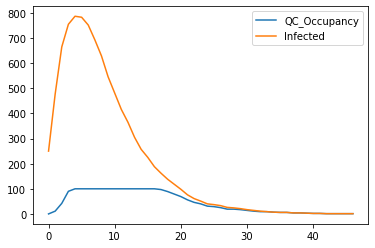

In [25]:
StartingState = 0.25
quarantine=True
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
averageMaxCapacityDay = 0
averageMaxCapacity = 0

for i in range(10):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties

    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))

# Scenario 2c. Quarantine Centers; 50% Infection at Start
StartingState = 50%

Quarantine=True

Social Distancing=False

Average number of days before stabilization: 44.2
Average of the Day with peak Infection (844.2): 3.0
Average Number of Casualties: 76.3
Average of Max Quarantine centre capacity utilized: 100.0
Average of Max Quarantine centre capacity utilized at: 3.1


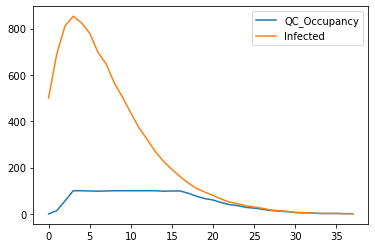

In [26]:
StartingState = 0.50
quarantine=True
socialDistancing=False
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
averageMaxCapacityDay = 0
averageMaxCapacity = 0

for i in range(10):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties

    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))

# Enabling Social Distancing Norms
Enable social distancing norms in addition to quaratine centers for each baseline and see how the plots change
In the line plot, include a plot for capacity of qurantine center too

In [27]:
# Add code to generate plots with social distancing and quarantine centers here

# Scenario 3a. Enforcing Social Distancing Norms; 10% Infection at Start
StartingState = 10%

Quarantine=True

Social Distancing=True

Average number of days before stabilization: 98.7
Average of the Day with peak Infection (262.6): 10.2
Average Number of Casualties: 68.4
Average of Max Quarantine centre capacity utilized: 98.5
Average of Max Quarantine centre capacity utilized at: 14.5


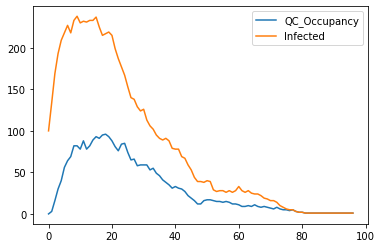

In [28]:
StartingState = 0.10
quarantine=True
socialDistancing=True
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
averageMaxCapacity = 0
averageMaxCapacityDay = 0

for i in range(10):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties

    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))

# Scenario 3b. Enforcing Social Distancing Norms; 25% Infection at Start
StartingState = 25%

Quarantine=True

Social Distancing=True

Average number of days before stabilization: 81.0
Average of the Day with peak Infection (368.9): 5.0
Average Number of Casualties: 68.5
Average of Max Quarantine centre capacity utilized: 100.0
Average of Max Quarantine centre capacity utilized at: 6.4


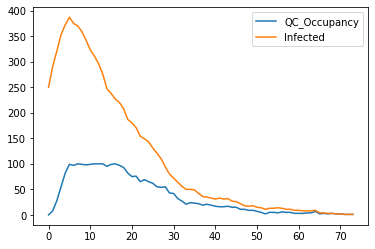

In [29]:
StartingState = 0.25
quarantine=True
socialDistancing=True
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageMaxCapacity = 0
averageCasualties = 0
averageMaxCapacityDay = 0

for i in range(10):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties

    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))

# Scenario 3c. Enforcing Social Distancing Norms; 50% Infection at Start
StartingState = 50%

Quarantine=True

Social Distancing=True

Average number of days before stabilization: 59.0
Average of the Day with peak Infection (557.3): 2.5
Average Number of Casualties: 69.8
Average of Max Quarantine centre capacity utilized: 100.0
Average of Max Quarantine centre capacity utilized at: 3.1


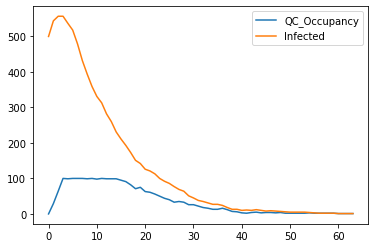

In [30]:
StartingState = 0.5
quarantine=True
socialDistancing=True
averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageMaxCapacity = 0
averageCasualties = 0
averageMaxCapacityDay = 0

for i in range(10):

    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageMaxCapacity += QC_Occupancy.max()
    averageMaxCapacityDay += QC_Occupancy.idxmax()
    averageCasualties += Casualties

    if i == 9:
        QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))
print('Average of Max Quarantine centre capacity utilized: ' + str(averageMaxCapacity/10))
print('Average of Max Quarantine centre capacity utilized at: ' + str(averageMaxCapacityDay/10))